In [3]:
import pandas as pd
import numpy as np
import re
import string
from string import digits
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# Load the data
train_data = pd.read_table('/content/drive/MyDrive/FINAL/train.csv', sep=',', names=['question','sql'])
val_data = pd.read_table('/content/drive/MyDrive/FINAL/validation.csv', sep=',', names=['question','sql'])
test_data = pd.read_table('/content/drive/MyDrive/FINAL/test.csv', sep=',', names=['question','sql'])




# Preprocess the data
def preprocess(text):
    text = text.lower()
    text = re.sub("'", '', text)
    text = re.sub(",", " COMMA", text)
    exclude = set(string.punctuation)
    text = ''.join(ch for ch in text if ch not in exclude)
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)
    return text

train_data.question = train_data.question.apply(preprocess)
train_data.sql = train_data.sql.apply(preprocess)

val_data.question = val_data.question.apply(preprocess)
val_data.sql = val_data.sql.apply(preprocess)

test_data.question = test_data.question.apply(preprocess)

# Add start and end tokens to SQL sentences
train_data.sql = train_data.sql.apply(lambda x: 'start ' + x + ' end')
val_data.sql = val_data.sql.apply(lambda x: 'start ' + x + ' end')



# Tokenize the input and output sentences
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(train_data.question)
input_sequences_train = eng_tokenizer.texts_to_sequences(train_data.question)
input_sequences_train = pad_sequences(input_sequences_train, padding='post')

input_sequences_val = eng_tokenizer.texts_to_sequences(val_data.question)
input_sequences_val = pad_sequences(input_sequences_val, padding='post')

sql_tokenizer = Tokenizer()
sql_tokenizer.fit_on_texts(train_data.sql)
output_sequences_train = sql_tokenizer.texts_to_sequences(train_data.sql)
output_sequences_train = pad_sequences(output_sequences_train, padding='post')

output_sequences_val = sql_tokenizer.texts_to_sequences(val_data.sql)
output_sequences_val = pad_sequences(output_sequences_val, padding='post')

# Compute max_input_length and max_output_length
max_input_length = input_sequences_train.shape[1]
max_output_length = output_sequences_train.shape[1]







In [4]:
glove_file = '/content/drive/MyDrive/FINAL/glove.6B.50d.txt'
word2vec_output_file = '/content/drive/MyDrive/glove.6B.50d.word2vec.txt'

# Convert GloVe embeddings to Word2Vec format
glove2word2vec(glove_file, word2vec_output_file)

# Load the converted Word2Vec embeddings
word_vectors = KeyedVectors.load_word2vec_format(word2vec_output_file)

# Create embedding matrix for the input vocabulary
input_vocab_size = len(eng_tokenizer.word_index) + 1
embedding_size = word_vectors.vector_size
embedding_matrix = np.zeros((input_vocab_size, embedding_size))
for word, i in eng_tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]




<ipython-input-4-0ccbcc5f1a33>:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_output_file)


In [5]:
# Define the model architecture
hidden_size = 512
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(input_vocab_size, embedding_size, weights=[embedding_matrix], trainable=False)(encoder_inputs)
encoder_lstm = LSTM(hidden_size, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

output_vocab_size = len(sql_tokenizer.word_index) + 1
output_embedding_matrix = np.zeros((output_vocab_size, embedding_size))
for word, i in sql_tokenizer.word_index.items():
    if word in word_vectors:
        output_embedding_matrix[i] = word_vectors[word]

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(output_vocab_size, embedding_size, weights=[output_embedding_matrix], trainable=False)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)



# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


from keras.callbacks import EarlyStopping


# Define the early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit([input_sequences_train, output_sequences_train[:,:-1]],
                    output_sequences_train.reshape(output_sequences_train.shape[0], output_sequences_train.shape[1], 1)[:,1:],
                    epochs=10, batch_size=64,
                    validation_data=([input_sequences_val, output_sequences_val[:,:-1]],
                                     output_sequences_val.reshape(output_sequences_val.shape[0], output_sequences_val.shape[1], 1)[:,1:]),
                    callbacks=[early_stopping])

Epoch 1/10
881/881 [==============================] - 143s 151ms/step - loss: 0.8407 - accuracy: 0.8977 - val_loss: 0.9004 - val_accuracy: 0.8655
Epoch 2/10
881/881 [==============================] - 139s 158ms/step - loss: 0.5425 - accuracy: 0.9195 - val_loss: 0.7253 - val_accuracy: 0.8825
Epoch 3/10
881/881 [==============================] - 139s 158ms/step - loss: 0.4345 - accuracy: 0.9292 - val_loss: 0.6083 - val_accuracy: 0.8976
Epoch 4/10
881/881 [==============================] - 137s 156ms/step - loss: 0.3482 - accuracy: 0.9385 - val_loss: 0.5345 - val_accuracy: 0.9089
Epoch 5/10
881/881 [==============================] - 137s 156ms/step - loss: 0.2823 - accuracy: 0.9457 - val_loss: 0.4962 - val_accuracy: 0.9151
Epoch 6/10
881/881 [==============================] - 137s 156ms/step - loss: 0.2312 - accuracy: 0.9521 - val_loss: 0.4693 - val_accuracy: 0.9200
Epoch 7/10
881/881 [==============================] - 138s 156ms/step - loss: 0.1917 - accuracy: 0.9583 - val_loss: 0.4577 -

In [ ]:
### NO NEED TO RUN THIS - error



# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
          epochs=10, batch_size=64,
          validation_data=([X_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]),
          callbacks=[early_stopping]
          )


In [ ]:
### NO NEED TO RUN THIS - error


# Evaluate the model on the validation dataset
val_loss, val_acc = model.evaluate([X_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:])
print('Validation loss:', val_loss)
print('Validation accuracy:', val_acc)

# Load the test data
test_data = pd.read_table('/content/drive/MyDrive/FINAL/test.csv', sep=',', names=['question','sql'])
test_data.question = test_data.question.apply(preprocess)

# Tokenize the test data
test_sequences = eng_tokenizer.texts_to_sequences(test_data.question)
test_sequences = pad_sequences(test_sequences, padding='post')

# Generate predictions for the test data
predictions = model.predict([test_sequences, np.zeros((len(test_sequences), max_output_length))])
predicted_sequences = np.argmax(predictions, axis=2)

# Convert the predicted sequences to SQL sentences
def sequence_to_sql(sequence):
    sql = []
    for idx in sequence:
        if idx == 0:
            break
        word = sql_tokenizer.index_word[idx]
        sql.append(word)
    return ' '.join(sql)

predicted_sql = [sequence_to_sql(seq) for seq in predicted_sequences]

# Add the predicted SQL sentences to the test data
test_data['predicted_sql'] = predicted_sql

# Print the test data with predicted SQL sentences
print(test_data[['question', 'sql', 'predicted_sql']])

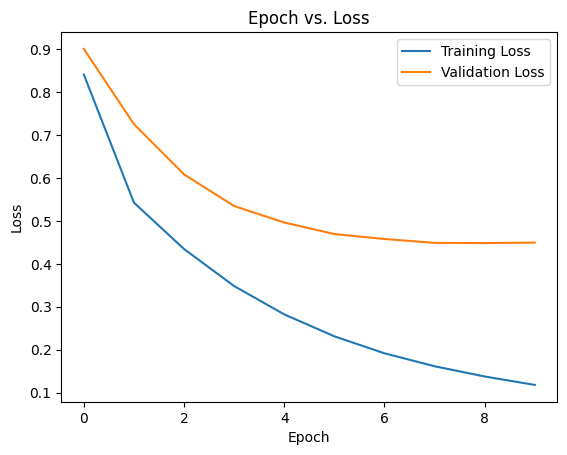

In [6]:
# Plot the epoch vs. loss graph
import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Epoch vs. Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [ ]:
### NO NEED TO RUN THIS - error


# Evaluate the model
_, acc = model.evaluate([X_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:])
print("Validation accuracy:", acc)

100/100 [==============================] - 2s 22ms/step - loss: 0.6461 - accuracy: 0.9088
Validation accuracy: 0.9088007807731628


In [8]:
# lines = train_data


# # Tokenize the input and output sentences
# eng_tokenizer = Tokenizer()
# eng_tokenizer.fit_on_texts(lines.question)
# input_sequences = eng_tokenizer.texts_to_sequences(lines.question)
# input_sequences = pad_sequences(input_sequences, padding='post')

# sql_tokenizer = Tokenizer()
# sql_tokenizer.fit_on_texts(lines.sql)
# # Add 'start_' token manually to the word index
# sql_tokenizer.word_index['start'] = len(sql_tokenizer.word_index) + 1
# output_sequences = sql_tokenizer.texts_to_sequences(lines.sql)
# output_sequences = pad_sequences(output_sequences, padding='post')

# Generate predictions
def predict_sequence(input_sequence):
    states_value = encoder_model.predict(input_sequence)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = sql_tokenizer.word_index['start']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = sql_tokenizer.index_word[sampled_token_index]
        if (sampled_token != 'end' and sampled_token != 'start'):
            decoded_sentence += ' ' + sampled_token
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_output_length-1)):
            stop_condition = True
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence.strip()


In [7]:
# Create encoder and decoder models for prediction
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [27]:
## Save the model

# model.save("/content/drive/MyDrive/FINAL/trained_model2_with_encoder")

In [25]:
encoder_inputs

<KerasTensor: shape=(None, None) dtype=float32 (created by layer 'input_1')>

In [9]:
a = test_data.iloc[69]
print(a.question)
print(a.sql)
print("\n")

# Test the model
test_input = a.question
test_input_seq = eng_tokenizer.texts_to_sequences([test_input])
test_input_seq = pad_sequences(test_input_seq, maxlen=max_input_length, padding='post')
pred = predict_sequence(test_input_seq)
print("Input sentence:", test_input)
print("Predicted SQL query:", pred)

what is the lowest group to earn  points
SELECT MIN Group stage FROM table WHERE Points = 886.6


1/1 [==============================] - 0s 20ms/step
Input sentence: what is the lowest group to earn  points
Predicted SQL query: select min from table where points


In [29]:
print(max_input_length)
print(max_output_length)

42
58


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 50)     1405600     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 50)     1279500     ['input_2[0][0]']                
                                                                                              

In [12]:
!nvidia-smi

Sun Jun  4 14:30:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    27W /  70W |   4835MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
model.save("/content/drive/MyDrive/FINAL/TRAINED/hijo_diusa_folder_wala/hijo_diuso_ko_model")

In [13]:
encoder_model.save("/content/drive/MyDrive/FINAL/TRAINED/hijo_diusa_folder_wala/hijo_diuso_ko_model_encoder")
decoder_model.save("/content/drive/MyDrive/FINAL/TRAINED/hijo_diusa_folder_wala/hijo_diusa_ko_model_decoder")